<a href="https://colab.research.google.com/github/DanishFaraaz/Deep-Learning-Projects/blob/main/25_Keras_Google_Deep_Dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file('castara-tobago.jpeg', 'https://github.com/rajeevratan84/ModernComputerVision/raw/main/castara-tobago.jpeg')
result_prefix = 'sky_dream'

# These are the names of the layers we want to maximize activation
layer_settings = {
    'mixed4': 1.0,
    'mixed5': 1.5,
    'mixed6': 2.0,
    'mixed7': 2.5,
}

step = 0.01 #Gradient ascent step size
num_octave = 3 #Number of scales at which to run the gradient ascent
octave_scale = 1.4 #Size ration between the scales
iterations = 20 #Number of ascent steps per scale
max_loss = 15.0

233568/233568 [==============================] - 0s 0us/step


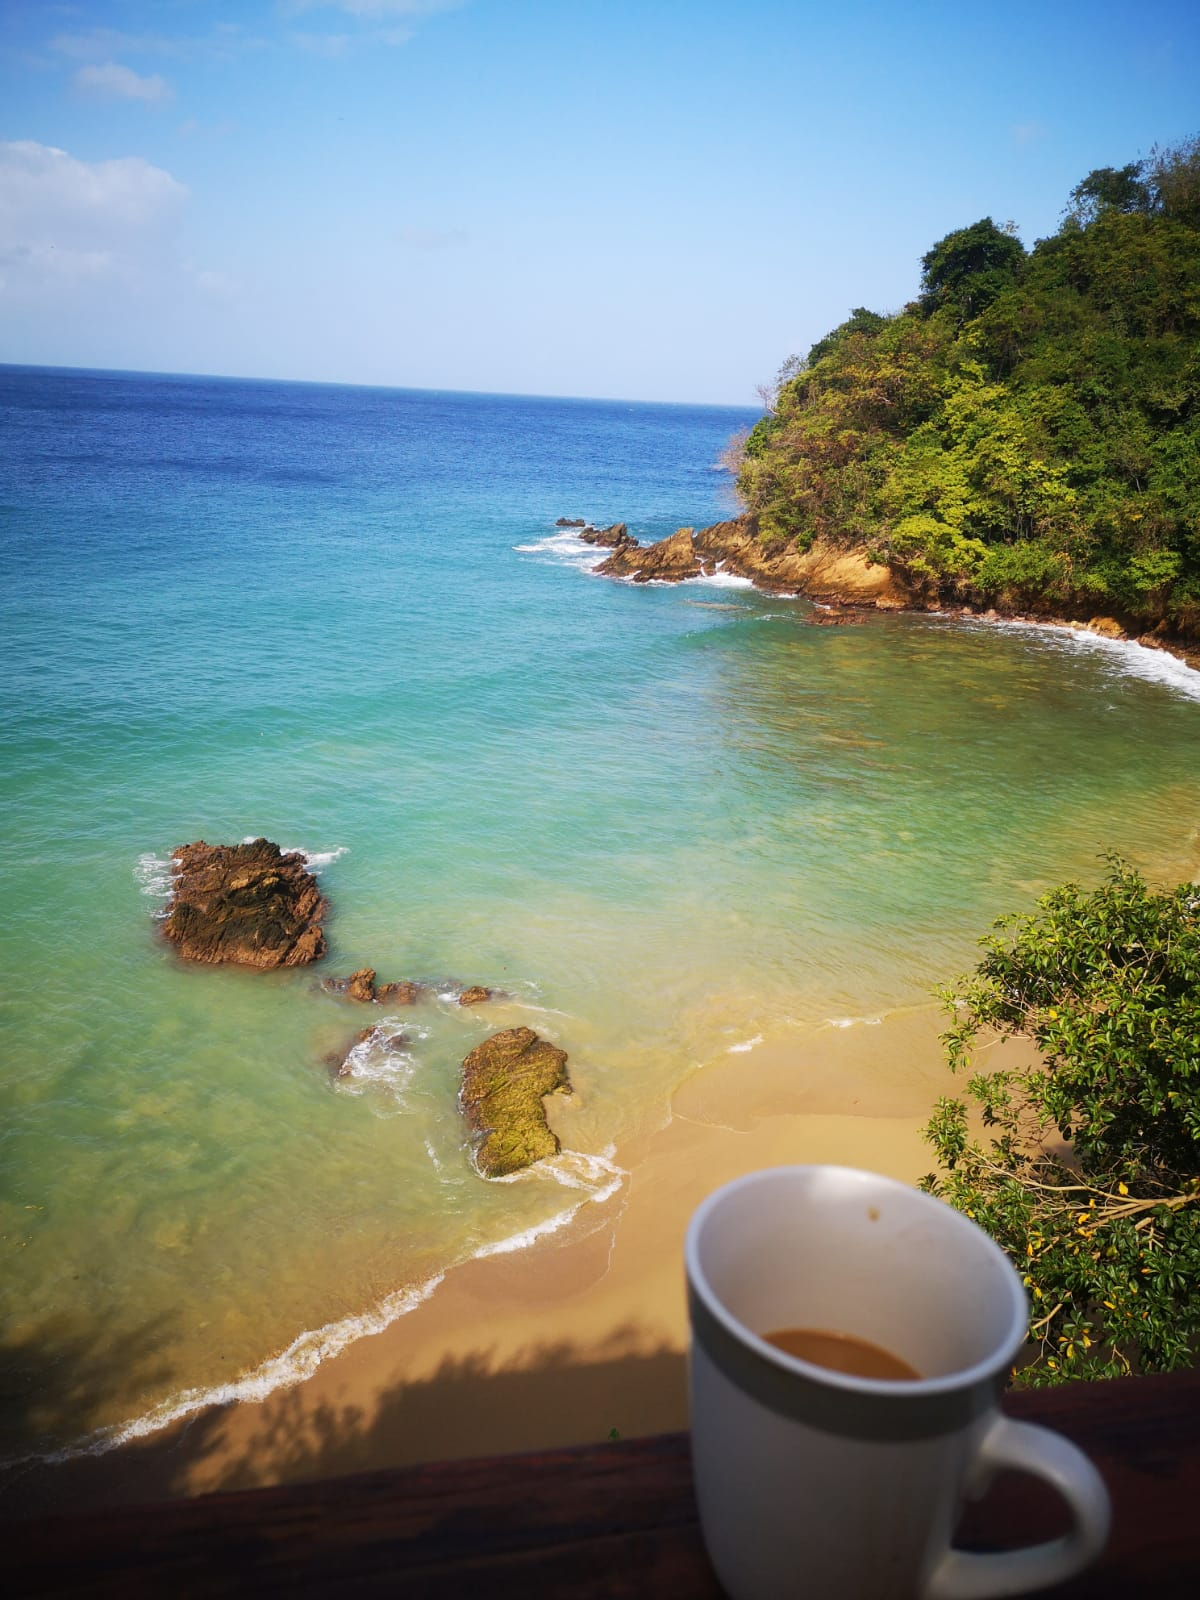

In [2]:
from IPython.display import Image, display

display(Image(base_image_path))

**Create image preprocessing and deprocessing utilities**

In [3]:
def preprocess_image(image_path):
  img = keras.preprocessing.image.load_img(image_path)
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = inception_v3.preprocess_input(img)
  return img

def deprocess_img(x):
  x = x.reshape((x.shape[1], x.shape[2], 3))
  x /= 2.0
  x += 0.5
  x *= 255.0
  x = np.clip(x, 0, 255).astype('uint8')
  return x

**Compute Deep Dream Loss**

In [6]:
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

87910968/87910968 [==============================] - 1s 0us/step


In [7]:
def compute_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    scaling = tf.reduce_prod(tf.cast(tf.shape(activation), 'float32'))
    loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
  return loss

**Setup gradient ascent loop for one octave**

In [8]:
from keras.src.optimizers.schedules import learning_rate_schedule
@tf.function

def gradient_ascent_step(img, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss = compute_loss(img)
  grads = tape.gradient(loss, img)
  grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
  img += learning_rate * grads
  return loss, img

def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
  for i in range(iterations):
    loss, img = gradient_ascent_step(img, learning_rate)
    if max_loss is not None and loss > max_loss:
      break
    print('... Loss value at step %d: %.2f' % (i, loss))
  return img

**Run the training loop, iterating over different octave**

In [9]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]

for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)

for i, shape in enumerate(successive_shapes):
  print('Preprocessing octave %d with shape %s' % (i, shape))
  img = tf.image.resize(img, shape)
  img = gradient_ascent_loop(
      img, iterations=iterations, learning_rate=step, max_loss=max_loss
  )
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img

  img += lost_detail
  shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + '.png', deprocess_img(img.numpy()))

Preprocessing octave 0 with shape (816, 612)
... Loss value at step 0: 0.60
... Loss value at step 1: 0.77
... Loss value at step 2: 1.00
... Loss value at step 3: 1.25
... Loss value at step 4: 1.52
... Loss value at step 5: 1.76
... Loss value at step 6: 2.02
... Loss value at step 7: 2.24
... Loss value at step 8: 2.52
... Loss value at step 9: 2.70
... Loss value at step 10: 2.98
... Loss value at step 11: 3.19
... Loss value at step 12: 3.39
... Loss value at step 13: 3.58
... Loss value at step 14: 3.85
... Loss value at step 15: 4.04
... Loss value at step 16: 4.26
... Loss value at step 17: 4.45
... Loss value at step 18: 4.64
... Loss value at step 19: 4.86
Preprocessing octave 1 with shape (1142, 857)
... Loss value at step 0: 1.13
... Loss value at step 1: 1.81
... Loss value at step 2: 2.19
... Loss value at step 3: 2.56
... Loss value at step 4: 2.89
... Loss value at step 5: 3.24
... Loss value at step 6: 3.50
... Loss value at step 7: 3.80
... Loss value at step 8: 4.06


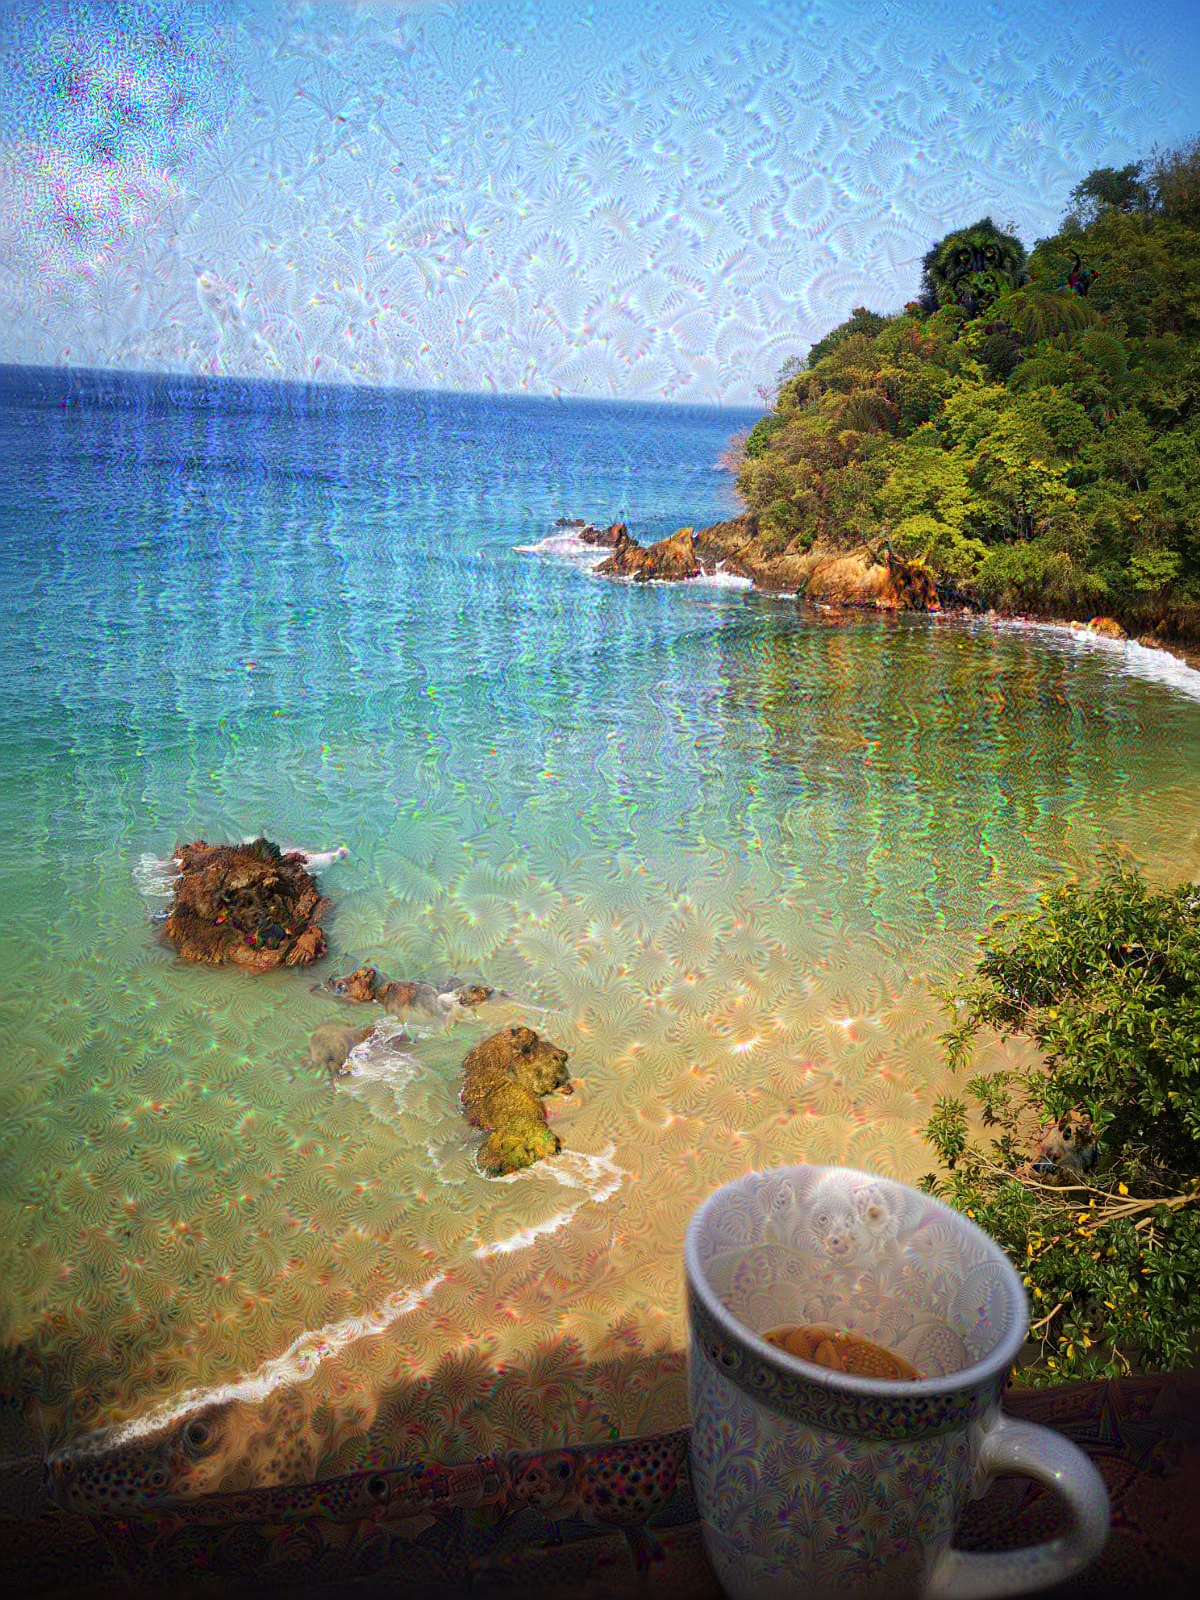

In [10]:
display(Image(result_prefix + '.png'))